# Convolutional neural network for 1 second samples

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow.keras as keras
import json
from sklearn.utils import shuffle
from itertools import product

from google.colab import drive
import glob

## Reading data

### Mounting Google Drive

In [3]:
# Mounting drive
drive.mount('/content/drive')
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/motor_noise_classifier/preprocessed_data"

Mounted at /content/drive
melSpec_data_1sec.json		     segments25sec.csv
melSpec_data_2sec.json		     segments2sec.csv
melSpec_data_5sec.json		     segments2sec_overlap.csv
segments1sec.csv		     segments2sec_overlap_newLabels.csv
segments1sec_overlap.csv	     segments5sec.csv
segments1sec_overlap_newLabels.csv   segments5sec_overlap.csv
segments1sec_overlap_newLabels.xlsx


### Reading data from Google Drive

In [4]:
# copying audio data from Google drive
!mkdir preprocessed_data
!cd preprocessed_data
!cp -r '/content/drive/My Drive/motor_noise_classifier/preprocessed_data/melSpec_data_2sec.json' preprocessed_data/melSpec_data.json 
!cp -r '/content/drive/My Drive/motor_noise_classifier/preprocessed_data/segments2sec_overlap_newLabels.csv' preprocessed_data/segments2sec.csv
!cd .. 

# importing custom functions
!cp -r '/content/drive/My Drive/motor_noise_classifier/my_functions.py' my_functions.py
from my_functions import *

In [6]:
sample_length = 2

# 1 sec samples 
df_src = pd.read_csv("./preprocessed_data/segments2sec.csv", index_col=0)
mel_spec_metadata_file = 'melSpec_data.json'


with open(f'./preprocessed_data/{mel_spec_metadata_file}') as json_file:
    melSpec_data = json.load(json_file)

melSpec_data.keys()

dict_keys(['melSpecShape0', 'melSpecShape1', 'n_fft', 'hop_length'])

## Data preparation

### Forming melspectrograms from flat arrays

In [7]:
melSpec_shape = (melSpec_data['melSpecShape0'], melSpec_data['melSpecShape1'])

df = reshapeMelSpecs(df_src, melSpec_shape)
df.sample(5)

(2231, 220, 87)


,motorId,isGood,melSpec
1819,19,False,"[[-8.740806524261982, -9.770188009943157, -8.7..."
1033,11,True,"[[-20.88692703445353, -17.22570915052731, -13...."
1746,19,False,"[[-14.47413014151083, -12.547290636354967, -13..."
2027,21,False,"[[-5.242620061865143, -4.006431220281176, -4.5..."
406,5,False,"[[-6.875728854757771, -5.589509396372758, -6.0..."


## Train-Test Split

The dataset will be split with respect to the motor IDs  
- Test set $\sim 20\%$ - 5 motors
- Train/Validation set $\sim 20\%$  - 18 motors

In [8]:
# load presaved custom shuffled train test split motor list
!cp -r '/content/drive/My Drive/motor_noise_classifier/train_test_shuffled_list.csv' train_test_shuffled_list.csv 
custom_shuffled_list = np.loadtxt('./train_test_shuffled_list.csv')
custom_shuffled_list

array([ 6., 18., 13.,  1.,  8.,  7.,  2., 10., 17., 19., 23., 16., 14.,
        3., 20., 22., 15.,  4., 12., 11., 21.,  9.,  5.])

In [51]:
df_train, df_test, shuffled_list_of_motors = splitTrainTestByMotorId(df, 
                                                                     nb_of_test_motors=10, 
                                                                    #  custom_shuffled_list=custom_shuffled_list,
                                                                     threshold=0.55,
                                                                     print_results=True
                                                                     )

shuffled_list_of_motors [20 16  5  1 23  2 15 19  8 21 11  6 18 17 14 10 13 12 22  7  3  4  9]
trainSet [11  6 18 17 14 10 13 12 22  7  3  4  9]
testSet [20 16  5  1 23  2 15 19  8 21]


In [ ]:
# Save the train/test list split for further use
np.savetxt('/content/drive/My Drive/motor_noise_classifier/train_test_shuffled_list.csv', shuffled_list_of_motors, delimiter=',')

## Normalisation with respect to trainset minimum/maximum

In [10]:
## Change to minMaxScaler

train_minimum = np.array(list(df_train.melSpec)).min()
train_maximum = np.array(list(df_train.melSpec)).max()

df_train.melSpec = normalise_dataset(df_train.melSpec, train_minimum, train_maximum)
df_test.melSpec = normalise_dataset(df_test.melSpec, train_minimum, train_maximum)

In [11]:
df_train

,motorId,isGood,melSpec
194,3,True,"[[0.9752395984314497, 0.9841562921559256, 0.97..."
195,3,True,"[[0.7833029799673581, 0.8093362668595594, 0.83..."
196,3,True,"[[0.9281010272410144, 0.9494117437770989, 0.95..."
197,3,True,"[[0.9208593997078539, 0.9457622168221043, 0.96..."
198,3,True,"[[0.9187259120042007, 0.9453140563126099, 0.96..."
...,...,...,...
2226,23,True,"[[0.983919949894153, 1.0, 0.9893544376006085, ..."
2227,23,True,"[[0.9849866106962765, 1.0, 0.9897046189441846,..."
2228,23,True,"[[0.9848312795293584, 1.0, 0.9895461657811965,..."
2229,23,True,"[[0.9852606549700207, 1.0, 0.9888425812861347,..."


## Building a CNN model

### Test model

In [ ]:
input_submodel = buildCNNInputSubmodel(melSpec_shape)
middle_submodel = buildCNNMiddleSubmodel(nb_of_conv_layers=4,
                                         filter_numbers=[16, 32, 64, 128],
                                         kernel_sizes=[3 for i in range(4)],
                                         activations=['selu' for i in range(4)]
                                         )
output_submodel = Dense(1, activation='sigmoid', name='output')

model = buildModel([input_submodel, middle_submodel, output_submodel],
                   loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_submodel (Sequential)  (None, 140, 44, 1)       0         
                                                                 
 middle_submodel (Sequential  (None, 2048)             97152     
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 2049      
                                                                 
Total params: 99,201
Trainable params: 99,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
             keras.callbacks.EarlyStopping(
                 monitor="val_loss", 
                 patience=2,
                 verbose=0)
             ]

score, epoch_number = KfoldValidationCNNTraining(model,
                                                 df_train,
                                                 k_folds=4,
                                                 epochs=10,
                                                 callbacks=callbacks,
                                                 )

fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.9390863180160522, 1.0, 1.0, 1.0], mean: 0.9847715795040131
epochs: [3, 3, 3, 3], mean: 3.0


In [ ]:
score

0.9847715795040131

In [ ]:
epoch_number

3

## Grid Search

params:
- CNN archi
- activations
- batch size

In [12]:
callbacks = [keras.callbacks.EarlyStopping(
                 monitor="val_loss", 
                 patience=2,
                 verbose=0)
             ]

### Check activations 

In [13]:
filter_numbers = [ 
                  [16, 32], 
                #   [128,256],
                  [64, 128, 256]
                  ]
activations = ['relu', 'selu']
batch_sizes = [64] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes)), 
             columns=['filter_numbers', 'activation', 'batch_size'])
params

,filter_numbers,activation,batch_size
0,"[16, 32]",relu,64
1,"[16, 32]",selu,64
2,"[64, 128, 256]",relu,64
3,"[64, 128, 256]",selu,64


In [14]:
grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=4,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/4
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [1.0, 0.9965635538101196, 1.0, 1.0], mean: 0.9991408884525299
epochs: [19, 4, 4, 4], mean: 7.75
#2/4
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6666666865348816, 0.6666666865348816, 1.0, 1.0], mean: 0.8333333432674408
epochs: [6, 4, 4, 4], mean: 4.5
#3/4
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [1.0, 1.0, 1.0, 1.0], mean: 1.0
epochs: [20, 3, 3, 3], mean: 7.25
#4/4
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [1.0, 1.0, 1.0, 1.0], mean: 1.0
epochs: [12, 5, 3, 3], mean: 5.75


In [15]:
grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,epochs_nb,accuracy
0,2,"[16, 32]",relu,64,8,0.999141
1,2,"[16, 32]",selu,64,5,0.833333
2,3,"[64, 128, 256]",relu,64,8,1.000000
3,3,"[64, 128, 256]",selu,64,6,1.000000


<Figure size 432x288 with 0 Axes>

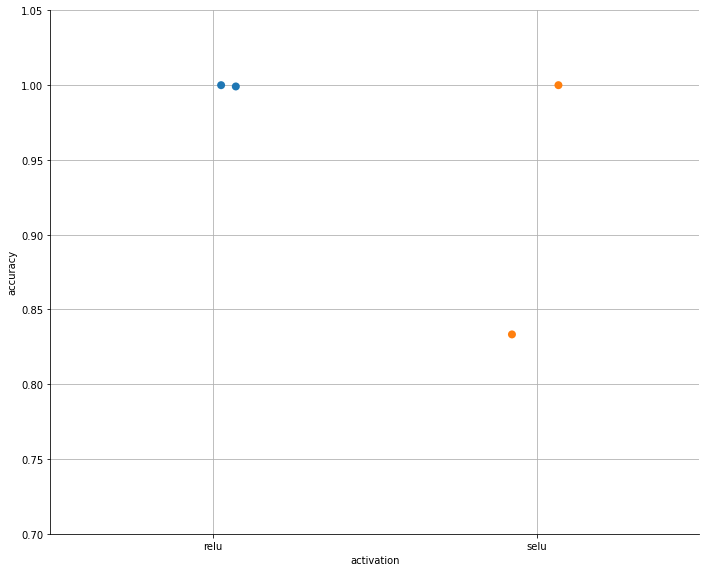

In [17]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='activation')

Activation function ReLu brought better results

### Check batch sizes

In [18]:
filter_numbers = [ 
                  [16, 32], 
                #   [128,256],
                  [64, 128, 256]
                  ]
activations = ['relu']
batch_sizes = [16, 32, 64, 128, 256] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes)), 
             columns=['filter_numbers', 'activation', 'batch_size'])
params

,filter_numbers,activation,batch_size
0,"[16, 32]",relu,16
1,"[16, 32]",relu,32
2,"[16, 32]",relu,64
3,"[16, 32]",relu,128
4,"[16, 32]",relu,256
5,"[64, 128, 256]",relu,16
6,"[64, 128, 256]",relu,32
7,"[64, 128, 256]",relu,64
8,"[64, 128, 256]",relu,128
9,"[64, 128, 256]",relu,256


In [19]:
grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=4,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6666666865348816, 1.0, 1.0, 1.0], mean: 0.9166666716337204
epochs: [3, 3, 3, 3], mean: 3.0
#2/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6632302403450012, 1.0, 1.0, 1.0], mean: 0.9158075600862503
epochs: [3, 3, 3, 3], mean: 3.0
#3/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.9896907210350037, 1.0, 1.0, 1.0], mean: 0.9974226802587509
epochs: [11, 11, 4, 3], mean: 7.25
#4/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6632302403450012, 0.7182130813598633, 0.9862542748451233, 1.0], mean: 0.841924399137497
epochs: [5, 5, 5, 4], mean: 4.75
#5/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6666666865348816, 1.0, 1.0, 0.8109965920448303], mean: 0.869415819644928
epochs: [5, 5, 5, 5], mean: 5.0
#6/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.9484536051750183, 1.0, 1.0, 1.0], mean: 0.9871134012937546
epochs: [5, 5, 3, 3], mean: 4.0
#7/10
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [1.0, 1.0, 

In [20]:
grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,epochs_nb,accuracy
0,2,"[16, 32]",relu,16,3,0.916667
1,2,"[16, 32]",relu,32,3,0.915808
2,2,"[16, 32]",relu,64,8,0.997423
3,2,"[16, 32]",relu,128,5,0.841924
4,2,"[16, 32]",relu,256,5,0.869416
5,3,"[64, 128, 256]",relu,16,4,0.987113
6,3,"[64, 128, 256]",relu,32,11,1.000000
7,3,"[64, 128, 256]",relu,64,7,1.000000
8,3,"[64, 128, 256]",relu,128,7,0.998282
9,3,"[64, 128, 256]",relu,256,5,0.727663


<Figure size 432x288 with 0 Axes>

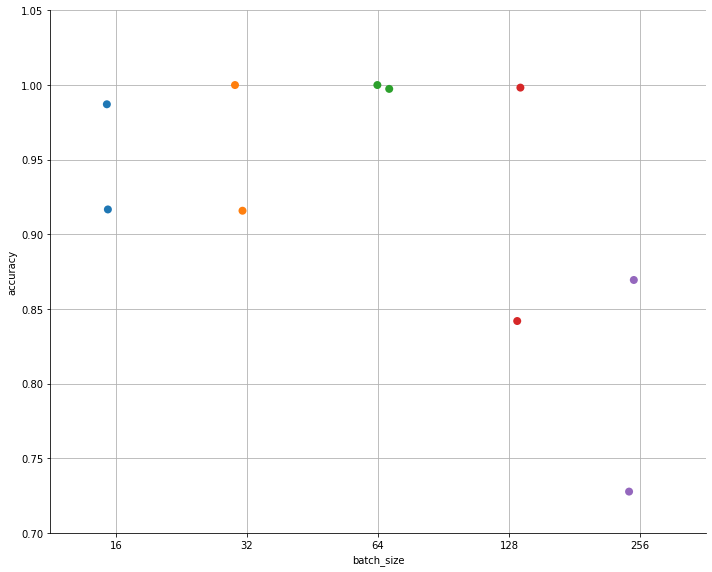

In [21]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='batch_size')

### Check different CNN layers parameters

In [22]:
filter_numbers = [ 
                  [16, 32], 
                  [32, 64],
                  [64,128],
                  [128,256],
                  [16, 32, 64],
                  [32, 64, 128],
                  [64, 128, 256],
                  ]
activations = ['relu']
batch_sizes = [64] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes)), 
             columns=['filter_numbers', 'activation', 'batch_size'])
params

,filter_numbers,activation,batch_size
0,"[16, 32]",relu,64
1,"[32, 64]",relu,64
2,"[64, 128]",relu,64
3,"[128, 256]",relu,64
4,"[16, 32, 64]",relu,64
5,"[32, 64, 128]",relu,64
6,"[64, 128, 256]",relu,64


In [23]:
grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=4,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6666666865348816, 1.0, 1.0, 1.0], mean: 0.9166666716337204
epochs: [8, 4, 4, 4], mean: 5.0
#2/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6666666865348816, 0.9828178882598877, 1.0, 1.0], mean: 0.9123711436986923
epochs: [5, 4, 4, 4], mean: 4.25
#3/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6666666865348816, 0.2886597812175751, 0.7044673562049866, 1.0], mean: 0.6649484559893608
epochs: [3, 3, 3, 3], mean: 3.0
#4/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.3195876181125641, 0.9862542748451233, 1.0, 1.0], mean: 0.8264604732394218
epochs: [3, 3, 3, 3], mean: 3.0
#5/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.6666666865348816, 1.0, 1.0, 1.0], mean: 0.9166666716337204
epochs: [6, 6, 5, 3], mean: 5.0
#6/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.5395188927650452, 1.0, 1.0, 1.0], mean: 0.8848797231912613
epochs: [5, 4, 4, 4], mean: 4.25
#7/7
fold: #1
fold: #2
fold: #3
fold: #4
accuracies: [0.

In [24]:
grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,epochs_nb,accuracy
0,2,"[16, 32]",relu,64,5,0.916667
1,2,"[32, 64]",relu,64,5,0.912371
2,2,"[64, 128]",relu,64,3,0.664948
3,2,"[128, 256]",relu,64,3,0.826460
4,3,"[16, 32, 64]",relu,64,5,0.916667
5,3,"[32, 64, 128]",relu,64,5,0.884880
6,3,"[64, 128, 256]",relu,64,3,0.911512


In [25]:
grid_search_results["filter_numbers_str"] = grid_search_results["filter_numbers"]
grid_search_results = grid_search_results.astype({"filter_numbers_str": str})

grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,epochs_nb,accuracy,filter_numbers_str
0,2,"[16, 32]",relu,64,5,0.916667,"[16, 32]"
1,2,"[32, 64]",relu,64,5,0.912371,"[32, 64]"
2,2,"[64, 128]",relu,64,3,0.664948,"[64, 128]"
3,2,"[128, 256]",relu,64,3,0.826460,"[128, 256]"
4,3,"[16, 32, 64]",relu,64,5,0.916667,"[16, 32, 64]"
5,3,"[32, 64, 128]",relu,64,5,0.884880,"[32, 64, 128]"
6,3,"[64, 128, 256]",relu,64,3,0.911512,"[64, 128, 256]"


<Figure size 432x288 with 0 Axes>

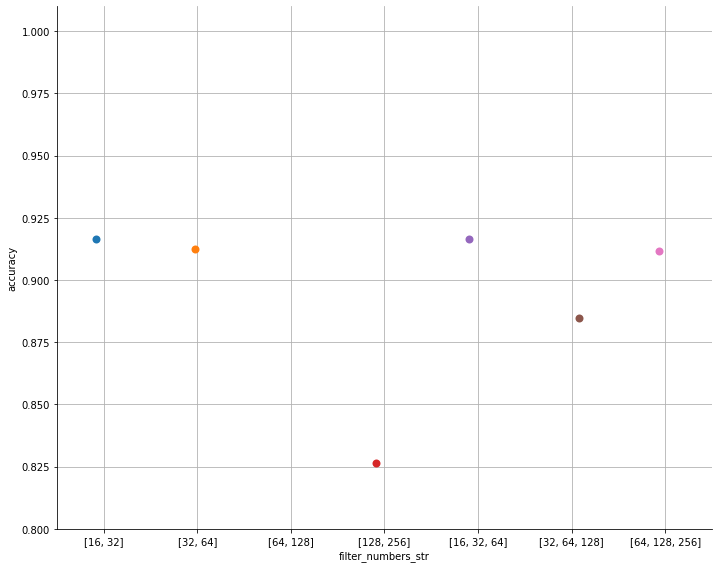

In [26]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='filter_numbers_str', ylim=[0.8, 1.01])

All the CNN structures performed very well (except [128,256]), so the simplest one will be used in the final model

## Final CNN model





In [27]:
samples_good_count = df.isGood.loc[df.isGood==True].count()
samples_bad_count = df.isGood.loc[df.isGood==False].count()

baseline = np.max([samples_good_count, samples_bad_count]) / (samples_good_count + samples_bad_count)
print(f"baseline to beat: {baseline*100 :.2f}%")

baseline to beat: 60.87%


The best parameters found in grid search:
- activation: ReLu
- batch size: 64
- hidden layers structure: [16, 32]

In [30]:
input_submodel = buildCNNInputSubmodel(melSpec_shape)
middle_submodel = buildCNNMiddleSubmodel(nb_of_conv_layers=2,
                                         filter_numbers=[16, 32],
                                         kernel_sizes=[3 for i in range(2)],
                                         activations=['relu' for i in range(2)]
                                         )
output_submodel = Dense(1, activation='sigmoid', name='output')

cnn_clf = buildModel([input_submodel, middle_submodel, output_submodel],
                   loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

cnn_clf.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_submodel (Sequential)  (None, 220, 87, 1)       0         
                                                                 
 middle_submodel (Sequential  (None, 36960)            4800      
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 36961     
                                                                 
Total params: 41,761
Trainable params: 41,761
Non-trainable params: 0
_________________________________________________________________


In [52]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", 
                                           patience=2, 
                                           verbose=0)
            ]

In [53]:
model_accuracy, epochs_nb = KfoldValidationCNNTraining(cnn_clf,
                                                       df_train,
                                                       k_folds=3,
                                                       epochs=20,
                                                       batch_size=64,
                                                       callbacks=callbacks
                                                       )


fold: #1
fold: #2
fold: #3
accuracies: [1.0, 1.0, 1.0], mean: 1.0
epochs: [7, 3, 3], mean: 4.333333333333333


### Training on a full training dataset

In [54]:
X_train, y_train = convertDatasetToArrays(df_train) 

In [55]:
history = cnn_clf.fit(X_train, 
                      y_train, 
                      epochs=int(epochs_nb) - 2,
                      batch_size=16,
                      )

Epoch 1/3
79/79 [==============================] - 1s 8ms/step - loss: 2.8249e-06 - accuracy: 1.0000
Epoch 2/3
79/79 [==============================] - 1s 8ms/step - loss: 1.8574e-06 - accuracy: 1.0000
Epoch 3/3
79/79 [==============================] - 1s 8ms/step - loss: 1.3810e-06 - accuracy: 1.0000


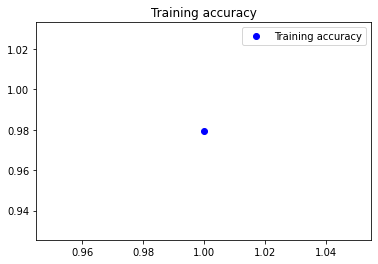

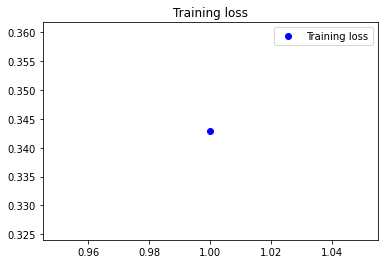

In [46]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
# val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
# val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
# plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
# plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training loss")
plt.legend()
plt.show()

### Test set evaluation

In [56]:
X_test, y_test, motorIds_test = convertDatasetToArrays(df_test, return_motorIds_array=True)

cnn_clf.evaluate(X_test, y_test)

31/31 [==============================] - 0s 6ms/step - loss: 1.2478 - accuracy: 0.9113


[1.2478045225143433, 0.9113401770591736]

In [57]:
preds_test = cnn_clf.predict(X_test)

preds_test_round = []
for pred in preds_test:
    pred_round = 1 if pred >= 0.5 else 0
    preds_test_round.append(pred_round)

In [58]:
results_table = countPredictionsByMotorId(y_test, preds_test_round, motorIds_test)
results_table.style.format({'good': '{:,.0f}',
                            'bad': '{:,.0f}',  
                            'prediction_confidence': '{:,.2%}'.format})

,good,bad,ground_truth,summed_prediction,prediction_confidence
motorId,,,,,
1,97,0,True,True,100.00%
2,97,0,True,True,100.00%
5,0,97,False,False,100.00%
8,97,0,True,True,100.00%
15,97,0,True,True,100.00%
16,0,97,False,False,100.00%
19,0,97,False,False,100.00%
20,0,97,False,False,100.00%
21,86,11,False,True,88.66%


In [59]:
final_accuracy = (results_table.ground_truth == results_table.summed_prediction).astype(int).sum() / len(results_table.ground_truth)
print(f"final accuracy: {final_accuracy*100 :.2f}%")

final accuracy: 90.00%
